In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# As the dataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-02-26 15:38:15.411475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 15:38:15.411607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 15:38:15.568422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
w,h = 400,400
batch_size = 32

train_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train'
test_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train'
val_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val'

train_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=0.3
)

test_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

val_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

train_dataset = train_img_gen.flow_from_directory(
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory(
    val_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [4]:
train_dataset.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

(32, 400, 400, 3)


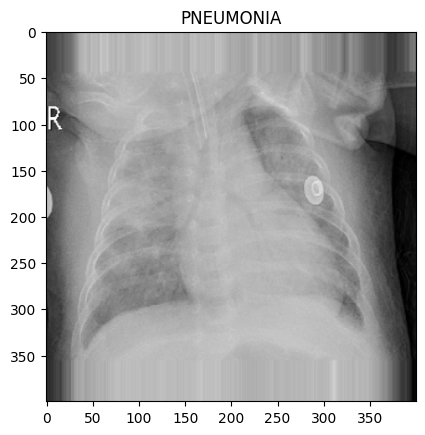

(32, 400, 400, 3)


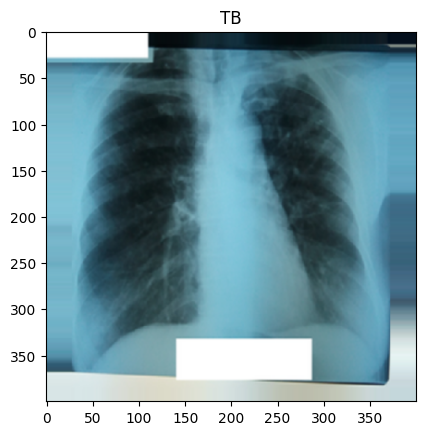

(32, 400, 400, 3)


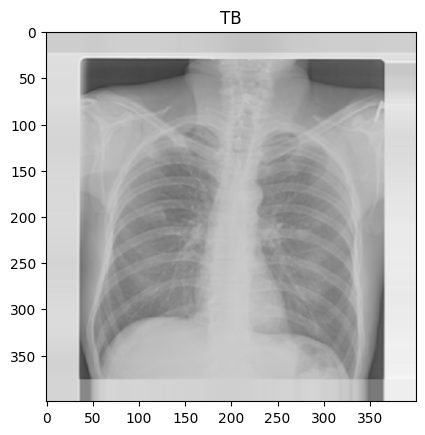

(32, 400, 400, 3)


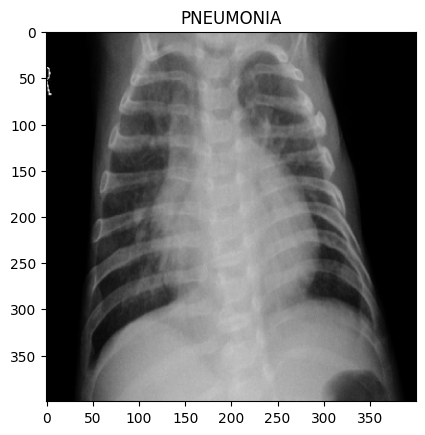

(32, 400, 400, 3)


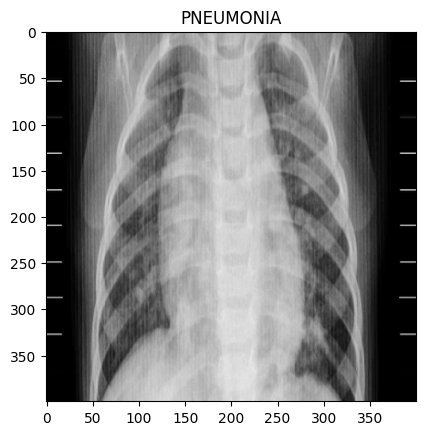

In [5]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TB']

for _ in range(5):
    img, label = train_dataset.next()
    print(img.shape)
    plt.title(classes[np.argmax(label[0])])
    plt.imshow(img[0])
    plt.show()

In [6]:
train_dataset.image_shape

(400, 400, 3)

In [7]:
model = models.Sequential()


model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())


model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))  
model.add(layers.Dense(4, activation='softmax')) 


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 64)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2534464)           0         
                                                                 
 dense (Dense)               (None, 128)               324411520 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

In [8]:
model = models.Sequential()


model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(4, activation='softmax'))  


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 398, 398, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 199, 199, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 197, 197, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 128)      

In [9]:
resnetModel = models.Sequential()

ResNet_101_V2 = tf.keras.applications.ResNet101V2(
                include_top = False,
                weights="imagenet",
                input_shape=(w,h,3),
                pooling='max',
                classes=4
            )

for layer in ResNet_101_V2.layers:
    layer.trainable = False

resnetModel.add(ResNet_101_V2)
resnetModel.add(layers.Flatten())
resnetModel.add(layers.Dense(512, activation='relu'))
resnetModel.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem


resnetModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnetModel.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 43677700 (166.62 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 42626560 (162.61 MB)
_________________________________________________________________


In [10]:

weight_path = '/kaggle/working/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)            

In [11]:
%%time
history = resnetModel.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[model_checkpoint])

Epoch 1/20


I0000 00:00:1708961942.240256     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 [==============================] - 323s 2s/step - loss: 2.3863 - accuracy: 0.8365 - val_loss: 0.7722 - val_accuracy: 0.7895
Epoch 2/20
198/198 [==============================] - 264s 1s/step - loss: 0.2376 - accuracy: 0.9175 - val_loss: 0.4980 - val_accuracy: 0.8158
Epoch 3/20
198/198 [==============================] - 261s 1s/step - loss: 0.2294 - accuracy: 0.9211 - val_loss: 0.5918 - val_accuracy: 0.7895
Epoch 4/20
198/198 [==============================] - 262s 1s/step - loss: 0.1676 - accuracy: 0.9376 - val_loss: 0.2783 - val_accuracy: 0.8684
Epoch 5/20
198/198 [==============================] - 260s 1s/step - loss: 0.1451 - accuracy: 0.9456 - val_loss: 0.4885 - val_accuracy: 0.8158
Epoch 6/20
198/198 [==============================] - 257s 1s/step - loss: 0.1796 - accuracy: 0.9334 - val_loss: 0.4425 - val_accuracy: 0.8421
Epoch 7/20
198/198 [==============================] - 263s 1s/step - loss: 0.1486 - accuracy: 0.9415 - val_loss: 0.3450 - val_accuracy: 0.8158
Epoch 8/20

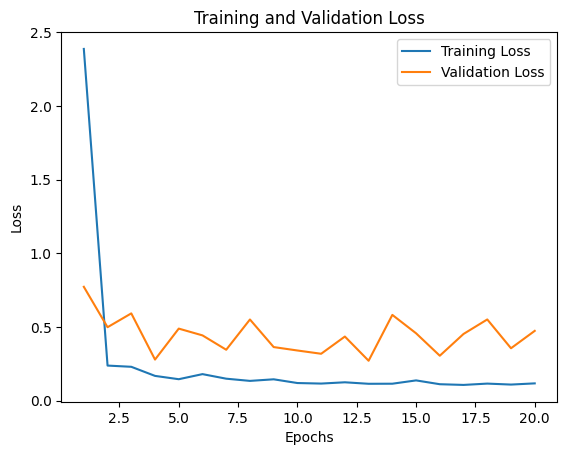

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(history.history['loss'])
# Plot the loss and val_loss
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = len(history.history['loss'])
#Plot the loss and val_loss


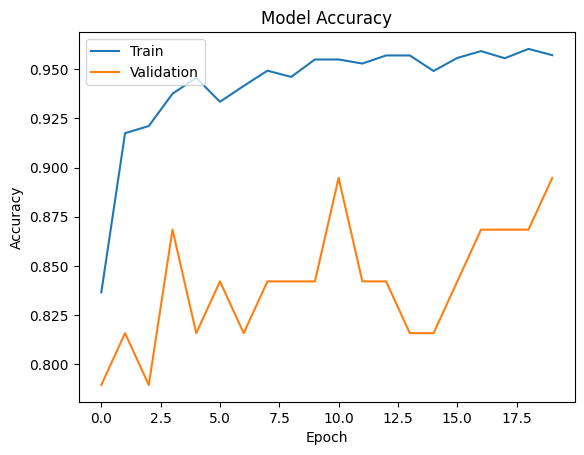

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# load best weights to model
resnetModel.load_weights(weight_path)

# make predictions
predictions = resnetModel.predict(test_dataset)
predictions


198/198 [==============================] - 110s 547ms/step


array([[9.99961615e-01, 3.08516337e-06, 1.05890849e-05, 2.47096305e-05],
       [9.99115765e-01, 6.21511117e-06, 7.59192451e-04, 1.18809156e-04],
       [9.86419380e-01, 8.83176326e-05, 1.26410834e-02, 8.51271208e-04],
       ...,
       [5.08936821e-04, 8.24562085e-06, 8.65670336e-06, 9.99474108e-01],
       [2.13360719e-04, 1.41754924e-07, 5.07242430e-06, 9.99781430e-01],
       [5.25379379e-04, 1.84982910e-05, 3.70232156e-05, 9.99419093e-01]],
      dtype=float32)

In [14]:
predicted_class = np.argmax(predictions, axis=1)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       460
           1       0.84      0.99      0.91      1341
           2       0.99      0.93      0.96      3875
           3       1.00      0.99      0.99       650

    accuracy                           0.95      6326
   macro avg       0.95      0.97      0.96      6326
weighted avg       0.96      0.95      0.96      6326

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}


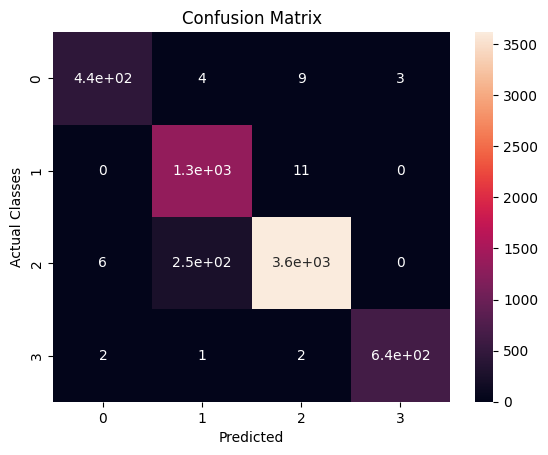

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_dataset.classes

sns.heatmap(confusion_matrix(true_labels, predicted_class), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_class))
print(test_dataset.class_indices)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [19]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(w, h, 3))

# Freeze ResNet50 layers
for layer in resnet50_model.layers:
    layer.trainable = False

# New model with ResNet50
resnet50_new = models.Sequential()
resnet50_new.add(resnet50_model)
resnet50_new.add(layers.GlobalAveragePooling2D())
resnet50_new.add(layers.Dense(4, activation='softmax'))

# Compile the model
resnet50_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
resnet50_new.fit(train_dataset, epochs=30)

# Test accuracy
resnet50_loss, resnet50_accuracy = resnet50_new.evaluate(test_dataset)
print("ResNet50 Accuracy:", resnet50_accuracy)


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/5
198/198 [==============================] - 256s 1s/step - loss: 1.0742 - accuracy: 0.6086
Epoch 2/5
198/198 [==============================] - 250s 1s/step - loss: 1.0237 - accuracy: 0.6114
Epoch 3/5
198/198 [==============================] - 250s 1s/step - loss: 0.9738 - accuracy: 0.6230
Epoch 4/5
198/198 [==============================] - 253s 1s/step - loss: 0.9477 - accuracy: 0.6250
Epoch 5/5
198/198 [==============================] - 93s 458ms/step - loss: 0.8884 - accuracy: 0.6329
ResNet50 Accuracy: 0.6329433917999268


In [29]:
from sklearn.metrics import classification_report

# Generate classification report for SVM
svm_report = classification_report(test_dataset.classes, svm_predictions, target_names=classes)
print("SVM Classification Report:")
print(svm_report)

# Generate classification report for Random Forest
rf_report = classification_report(test_dataset.classes, rf_predictions, target_names=classes)
print("\nRandom Forest Classification Report:")
print(rf_report)


SVM Classification Report:
              precision    recall  f1-score   support

     COVID19       0.00      0.00      0.00       460
      NORMAL       0.00      0.00      0.00      1341
   PNEUMONIA       0.61      1.00      0.76      3875
          TB       0.00      0.00      0.00       650

    accuracy                           0.61      6326
   macro avg       0.15      0.25      0.19      6326
weighted avg       0.38      0.61      0.47      6326


Random Forest Classification Report:
              precision    recall  f1-score   support

     COVID19       0.03      0.02      0.02       460
      NORMAL       0.26      0.18      0.21      1341
   PNEUMONIA       0.62      0.80      0.70      3875
          TB       0.04      0.02      0.02       650

    accuracy                           0.53      6326
   macro avg       0.24      0.25      0.24      6326
weighted avg       0.44      0.53      0.48      6326



In [31]:
# AlexNet Model
alexnetModel = models.Sequential()

# 1st Convolutional Layer
alexnetModel.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(w,h,3)))
alexnetModel.add(layers.BatchNormalization())
alexnetModel.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# 2nd Convolutional Layer
alexnetModel.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
alexnetModel.add(layers.BatchNormalization())
alexnetModel.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# 3rd Convolutional Layer
alexnetModel.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))

# 4th Convolutional Layer
alexnetModel.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))

# 5th Convolutional Layer
alexnetModel.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
alexnetModel.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Passing it to a Fully Connected layer
alexnetModel.add(layers.Flatten())

# 1st Fully Connected Layer
alexnetModel.add(layers.Dense(4096, activation='relu'))

# 2nd Fully Connected Layer
alexnetModel.add(layers.Dense(4096, activation='relu'))

# Output Layer
alexnetModel.add(layers.Dense(4, activation='softmax')) # As it's a multi-class problem

# Compile Model
alexnetModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate model
alexnetModel.fit(train_dataset,
                 epochs=30,
                 steps_per_epoch=len(train_dataset),
                 validation_data=val_dataset,
                 validation_steps=len(val_dataset))

alexnetModel.evaluate(test_dataset)


Epoch 1/30
198/198 [==============================] - 264s 1s/step - loss: 3.7294 - accuracy: 0.6280 - val_loss: 1.5368 - val_accuracy: 0.3158
Epoch 2/30
198/198 [==============================] - 249s 1s/step - loss: 0.7943 - accuracy: 0.6914 - val_loss: 1.4027 - val_accuracy: 0.3947
Epoch 3/30
198/198 [==============================] - 251s 1s/step - loss: 0.6991 - accuracy: 0.7335 - val_loss: 2.7575 - val_accuracy: 0.2105
Epoch 4/30
198/198 [==============================] - 252s 1s/step - loss: 0.6220 - accuracy: 0.7760 - val_loss: 1.5903 - val_accuracy: 0.2368
Epoch 5/30
198/198 [==============================] - 250s 1s/step - loss: 0.5955 - accuracy: 0.7713 - val_loss: 1.6262 - val_accuracy: 0.4211
Epoch 6/30
198/198 [==============================] - 252s 1s/step - loss: 0.4655 - accuracy: 0.8313 - val_loss: 1.1245 - val_accuracy: 0.5789
Epoch 7/30
198/198 [==============================] - 245s 1s/step - loss: 0.3802 - accuracy: 0.8531 - val_loss: 2.1170 - val_accuracy: 0.5263

[0.4328196346759796, 0.8675308227539062]

In [47]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(w, h, 3))

# Freeze ResNet50 layers
for layerfr in resnet50_model.layers:
    layer.trainable = False

# New model with ResNet50
resnet50_new = models.Sequential()
resnet50_new.add(resnet50_model)
resnet50_new.add(layers.GlobalAveragePooling2D())
resnet50_new.add(layers.Dense(4, activation='softmax'))

# Compile the model
resnet50_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
resnet50_new.fit(train_dataset, epochs=15)

# Test accuracy
resnet50_loss, resnet50_accuracy = resnet50_new.evaluate(test_dataset)
print("ResNet50 Accuracy:", resnet50_accuracy)


Epoch 1/100
198/198 [==============================] - 297s 1s/step - loss: 0.3843 - accuracy: 0.8615
Epoch 2/100
198/198 [==============================] - 270s 1s/step - loss: 0.2002 - accuracy: 0.9304
Epoch 3/100
198/198 [==============================] - 271s 1s/step - loss: 0.1703 - accuracy: 0.9363
Epoch 4/100
198/198 [==============================] - 270s 1s/step - loss: 0.1429 - accuracy: 0.9482
Epoch 5/100
198/198 [==============================] - 270s 1s/step - loss: 0.1557 - accuracy: 0.9437
Epoch 6/100
 14/198 [=>............................] - ETA: 4:10 - loss: 0.1496 - accuracy: 0.9487

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_9/resnet50/conv3_block1_1_conv/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/70703155.py", line 20, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[32,256,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_9/resnet50/conv3_block1_1_conv/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_234972]